# Data Loading

In [ ]:
import os
import pandas as pd
import numpy as np
import math
from google.colab import drive
from tqdm import tqdm
from pathlib import Path
from mplsoccer import Pitch
import torch
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.cluster import KMeans
from sklearn.model_selection import KFold
from sklearn.model_selection import GroupKFold
from catboost import CatBoostRegressor, Pool
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle, Arc
import matplotlib.patches as mpatches
import seaborn as sns
from torch import nn
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence
from torch.utils.data import Dataset, DataLoader
import koreanize_matplotlib
from sklearn.preprocessing import StandardScaler

In [ ]:
# Train 원본 로딩
train_df = pd.read_csv("./train.csv")
train_df = train_df.sort_values(["game_episode", "time_seconds", "action_id"]).reset_index(drop=True)
train_df["is_train"] = 1

# Test 원본 로딩
test_meta = pd.read_csv("./test.csv")
BASE_TEST_DIR = "/content/drive/MyDrive/DACON/K-League/test"

test_meta["path"] = (
    BASE_TEST_DIR + "/"
    + test_meta["game_id"].astype(str) + "/"
    + test_meta["game_episode"].astype(str)
    + ".csv"
)

episode_dfs = []

for _, row in tqdm(test_meta.iterrows(), total=len(test_meta)):
    ep_df = pd.read_csv(row["path"]).reset_index(drop=True)
    ep_df["game_id"] = row["game_id"]
    ep_df["game_episode"] = row["game_episode"]
    ep_df["is_train"] = 0
    episode_dfs.append(ep_df)

test_df = pd.concat(episode_dfs, ignore_index=True)
print(train_df.shape, test_df.shape)

# train + test 병합
df = pd.concat([train_df, test_df], ignore_index=True)
print(df.shape)

use_cols = [
    'game_id',
    'game_day', 'game_date',
    'home_score', 'away_score',
    'venue',
    'home_team_name_ko', 'away_team_name_ko'   # EDA용
]
# match_info 병합
df_match = pd.read_csv("./match_info.csv")
df_copy = df.merge(df_match[use_cols], on='game_id', how='left')

In [ ]:
# 대분류 game_episode(게임 ID + 전ㆍ후반)  / 중분류 time_seconds : 동에피소드 시간순서
df_copy = df_copy.sort_values(["game_id", "game_episode", "time_seconds"]).reset_index(drop=True)
if 'type_name' in df_copy.columns:
    df_copy = df_copy.rename(columns={'type_name': 'action_type'})
print("train/test + match_info 병합 = df_copy")
print(df_copy.info())

train/test + match_info 병합 = df_copy
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 409831 entries, 0 to 409830
Data columns (total 23 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   game_id            409831 non-null  int64  
 1   period_id          409831 non-null  int64  
 2   episode_id         409831 non-null  int64  
 3   time_seconds       409831 non-null  float64
 4   team_id            409831 non-null  int64  
 5   player_id          409831 non-null  int64  
 6   action_id          409831 non-null  int64  
 7   action_type        409831 non-null  object 
 8   result_name        248448 non-null  object 
 9   start_x            409831 non-null  float64
 10  start_y            409831 non-null  float64
 11  end_x              407417 non-null  float64
 12  end_y              407417 non-null  float64
 13  is_home            409831 non-null  bool   
 14  game_episode       409831 non-null  object 
 15  is_train      

# Preprocessing Functions

In [ ]:
# 전처리 & 학습 함수 정의
def add_episode_len(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    df["episode_len"] = df.groupby("game_episode")["action_id"].transform("count")
    return df

def split_train_test(df: pd.DataFrame, flag_col="is_train"):
    df_train = df[df[flag_col] == 1].copy()
    df_test  = df[df[flag_col] == 0].copy()
    return df_train, df_test

def sort_df(df: pd.DataFrame) -> pd.DataFrame:
    return df.sort_values(SORT_KEYS).reset_index(drop=True)

def get_last_event_per_episode(df: pd.DataFrame) -> pd.DataFrame:
    return (
        df.sort_values(SORT_KEYS)
          .groupby("game_episode", as_index=False)
          .tail(1)
          .reset_index(drop=True)
    )

def filter_train_targets(df: pd.DataFrame) -> pd.DataFrame:
    cond = df["end_x"].notnull() & df["end_y"].notnull()
    return df[cond].reset_index(drop=True)

def build_feature_cols(df: pd.DataFrame) -> list:
    # 존재하는 컬럼만 + 드랍 대상 제거 + 중복 제거
    cols = [c for c in FEATURE_CANDIDATES if c in df.columns]
    cols = [c for c in cols if c not in DROP_COLS]
    return list(dict.fromkeys(cols))

def build_cat_features(feature_cols: list) -> list:
    return [c for c in CAT_CANDIDATES if c in feature_cols]

def fill_missing(X_train: pd.DataFrame, X_test: pd.DataFrame, cat_features: list):
    X_train = X_train.copy()
    X_test  = X_test.copy()

    # 범주형: 문자열화
    for c in cat_features:
        X_train[c] = X_train[c].fillna("Missing").astype(str)
        X_test[c]  = X_test[c].fillna("Missing").astype(str)

    # numeric (의미상 0이 안전한 것만)
    for c in ["dx", "dy", "legal_speed"]:
        if c in X_train.columns:
            X_train[c] = X_train[c].fillna(0.0)
            X_test[c]  = X_test[c].fillna(0.0)

    return X_train, X_test

# Feature Engineering

--- Pipeline Start ---
Filtered Pass Events (Train Only: True): ['Pass' 'Pass_Corner' 'Goal Kick' 'Throw-In' 'Pass_Freekick' 'Cross']
Players with >= 5 passes: 438

--- Cluster Summary (Check this to define roles) ---
            start_x_mean  start_y_mean  pass_dist_mean  forward_mean
cluster_id                                                          
0              61.866001     49.769382       13.821746      0.475300
1              47.424854     32.852221       17.244856      0.624469
2              63.373416     27.772314       12.860367      0.463221
3              11.547747     32.940832       30.555394      0.956800
4              44.086435     50.512961       18.399140      0.645007
5              50.727673     13.848040       17.135792      0.614363


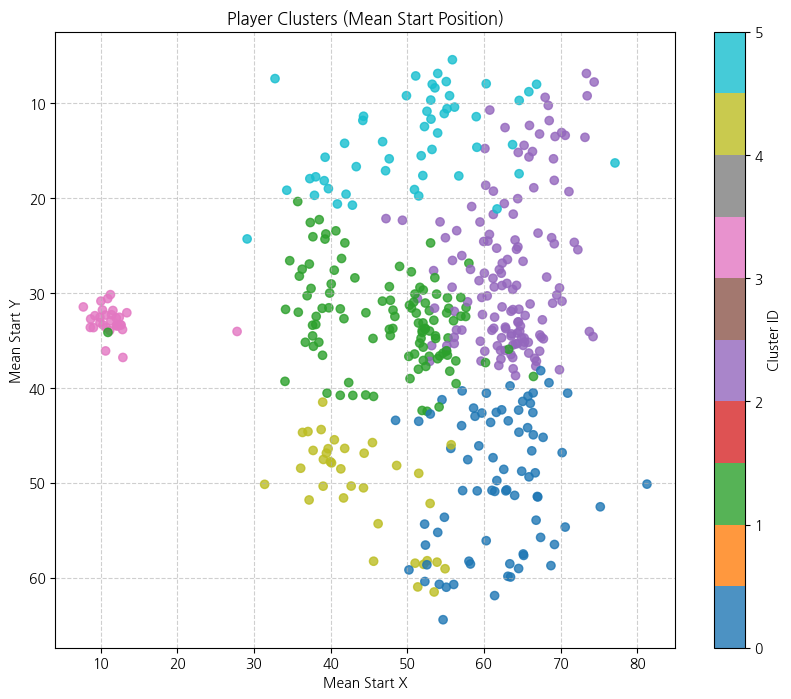


--- Final Role Label Counts in Original DF ---
player_role_label
mid_temp           148387
attack_temp         74091
mid2_temp           58155
right_wing_temp     53722
defense_temp        51182
GK_temp             23624
unknown               670
Name: count, dtype: int64
--- Pipeline End ---


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

# 1. 설정 및 상수 정의

# 분석 대상 패스 이벤트 타입 정의
PASS_EVENTS = [
    "Pass", "Pass_Freekick", "Pass_Corner",
    "Throw-In", "Goal Kick", "Cross"
]

INITIAL_ROLE_MAP = {
    0: "right_wing_temp",
    1: "mid_temp",
    2: "attack_temp",
    3: "GK_temp",
    4: "defense_temp",
    5: "mid2_temp"
}

# 2. 핵심 함수 정의

def load_and_filter_data(df_origin, train_only=True):
    """
    원본 데이터에서 패스 이벤트만 추출
    데이터 누수 방지를 위해 학습 데이터만 필터링
    """
    # 1. 데이터 누수 방지: 학습 데이터(is_train == 1)만 선택
    if train_only:
        df_filtered = df_origin[df_origin["is_train"] == 1].copy()
    else:
        df_filtered = df_origin.copy()

    # 2. 패스 관련 이벤트만 필터링
    df_pass = df_filtered[df_filtered["action_type"].isin(PASS_EVENTS)].copy()

    print(f"Filtered Pass Events (Train Only: {train_only}): {df_pass['action_type'].unique()}")
    return df_pass

def create_pass_features(df_pass, min_passes=5):
    """
    패스 거리, 방향 등의 기본 피처를 생성하고
    패스 횟수가 너무 적은 선수를 제외
    """
    # 기본 피처 계산
    df_pass["dx"] = df_pass["end_x"] - df_pass["start_x"]
    df_pass["dy"] = df_pass["end_y"] - df_pass["start_y"]
    df_pass["pass_dist"] = np.sqrt(df_pass["dx"]**2 + df_pass["dy"]**2)
    df_pass["forward"] = (df_pass["dx"] > 0).astype(int)
    df_pass["side_move"] = df_pass["dy"].abs()

    # 최소 패스 횟수 미만 선수 제거
    pass_counts = df_pass.groupby("player_id").size()
    valid_players = pass_counts[pass_counts >= min_passes].index

    df_pass_valid = df_pass[df_pass["player_id"].isin(valid_players)].copy()
    print(f"Players with >= {min_passes} passes: {len(valid_players)}")

    return df_pass_valid

def calculate_player_stats(df_pass_valid):
    """
    선수별로 패스 데이터의 평균/표준편차를 집계하여
    클러스터링에 사용할 입력 데이터 생성
    """
    # 선수별 집계
    agg_rules = {
        "start_x": ["mean"], "start_y": ["mean"],
        "end_x": ["mean"],   "end_y": ["mean"],
        "dx": ["mean"],      "dy": ["mean"],
        "pass_dist": ["mean", "std"],
        "forward": ["mean"], "side_move": ["mean"],
    }
    player_stats = df_pass_valid.groupby("player_id").agg(agg_rules)

    # MultiIndex 컬럼 평탄화
    player_stats.columns = ['_'.join(col).strip() for col in player_stats.columns.values]

    # 결측치 처리 (std 계산 시 패스가 1개면 NaN 발생 가능 -> 0으로 대체)
    player_stats_flat = player_stats.fillna(0)

    return player_stats_flat

def perform_clustering(player_stats_df, n_clusters=6, random_state=42):
    """
    집계된 선수 데이터를 스케일링하고 KMeans 클러스터링을 수행
    """
    # 스케일링 (StandardScaler)
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(player_stats_df)

    # KMeans 클러스터링
    kmeans = KMeans(n_clusters=n_clusters, random_state=random_state, n_init='auto')
    labels = kmeans.fit_predict(X_scaled)

    # 결과 데이터프레임에 클러스터 ID 추가
    results_df = player_stats_df.copy()
    results_df['cluster_id'] = labels

    return results_df, kmeans, scaler

def visualize_clusters(stats_df_with_cluster, title="Player Clusters (Mean Start Position)"):
    """
    결과 시각화
    """
    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(
        stats_df_with_cluster["start_x_mean"],
        stats_df_with_cluster["start_y_mean"],
        c=stats_df_with_cluster["cluster_id"],
        cmap="tab10",
        alpha=0.8
    )
    plt.colorbar(scatter, label="Cluster ID")
    plt.xlabel("Mean Start X")
    plt.ylabel("Mean Start Y")
    plt.title(title)
    plt.gca().invert_yaxis() # 축구장 좌표계 특성 반영
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.show()

# 3. 메인 실행

print("--- Pipeline Start ---")

# 1) 데이터 로드 및 필터링 (Train 데이터만 사용)
df_pass_train = load_and_filter_data(df_copy, train_only=True)

# 2) 피처 생성 및 유효 선수 필터링
df_pass_valid = create_pass_features(df_pass_train, min_passes=5)

# 3) 선수별 통계 집계
player_stats_flat = calculate_player_stats(df_pass_valid)

# 4) 클러스터링 수행 (k=6)
clustered_stats, kmeans_model, scaler_model = perform_clustering(player_stats_flat, n_clusters=6)

# 5) 클러스터 특성 확인 (이 결과를 보고 ROLE_MAP을 수정해야 함)
cluster_summary = clustered_stats.groupby("cluster_id").mean()
print("\n--- Cluster Summary (Check this to define roles) ---")
print(cluster_summary[['start_x_mean', 'start_y_mean', 'pass_dist_mean', 'forward_mean']])

# 6) 시각화 확인
visualize_clusters(clustered_stats)

# 4. 결과 매핑 및 원본 데이터 업데이트

# player_id -> cluster_id 매핑 딕셔너리 생성
id2cluster = clustered_stats['cluster_id'].to_dict()

# cluster_id -> 역할 이름(Role Label) 매핑 생성
id2role_label = {pid: INITIAL_ROLE_MAP.get(cid, "unknown") for pid, cid in id2cluster.items()}

# 원본 df_copy에 결과 반영
# 훈련 데이터에만 존재하는 선수들이므로, 매핑되지 않은 선수는 'unknown' 처리
df_copy["player_role_pass"] = df_copy["player_id"].map(id2cluster)
df_copy["player_role_label"] = df_copy["player_id"].map(id2role_label).fillna("unknown")

print("\n--- Final Role Label Counts in Original DF ---")
print(df_copy['player_role_label'].value_counts())
print("--- Pipeline End ---")

In [ ]:
# prev 피처 생성
order_col = "time_seconds"
df_copy = df_copy.sort_values(["game_episode", order_col]).copy()

n_prev = 1

base_cols = ["end_x", "end_y",'action_type', "result_name"]

for i in range(1, n_prev + 1):
    shifted = (
        df_copy
        .groupby("game_episode")[base_cols]
        .shift(i)
    )

    shifted.columns = [f"prev{i}_{col}" for col in base_cols]
    df_copy = pd.concat([df_copy, shifted], axis=1)

df_copy.head()

,game_id,period_id,episode_id,time_seconds,team_id,player_id,action_id,action_type,result_name,start_x,...,away_score,venue,home_team_name_ko,away_team_name_ko,player_role_pass,player_role_label,prev1_end_x,prev1_end_y,prev1_action_type,prev1_result_name
0,126283,1,1,0.667,2354,344559,0,Pass,Successful,52.418205,...,0,문수월드컵경기장,울산 HD FC,포항 스틸러스,0.0,right_wing_temp,NaN,NaN,NaN,NaN
1,126283,1,1,3.667,2354,250036,2,Pass,Successful,32.013240,...,0,문수월드컵경기장,울산 HD FC,포항 스틸러스,4.0,defense_temp,31.322445,38.274752,Pass,Successful
2,126283,1,1,4.968,2354,500145,4,Carry,NaN,37.371285,...,0,문수월드컵경기장,울산 HD FC,포항 스틸러스,2.0,attack_temp,37.371285,30.632980,Pass,Successful
3,126283,1,1,8.200,2354,500145,5,Pass,Successful,38.391570,...,0,문수월드컵경기장,울산 HD FC,포항 스틸러스,2.0,attack_temp,38.391570,24.613144,Carry,NaN
4,126283,1,1,11.633,2354,142106,7,Pass,Successful,34.578705,...,0,문수월드컵경기장,울산 HD FC,포항 스틸러스,5.0,mid2_temp,34.573350,5.545468,Pass,Successful


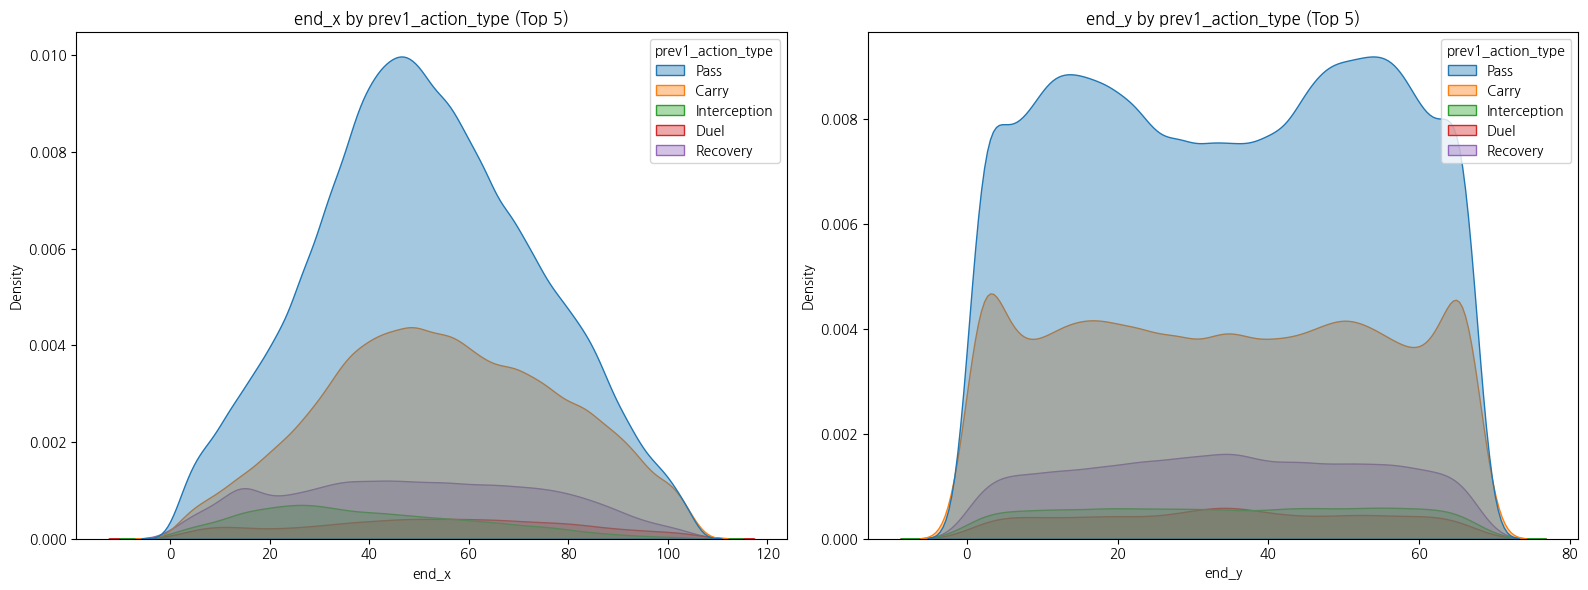

In [ ]:
#df_copy 1-step의 상위 5개의 type_name의 행동 분포확인
# Top 5 prev_action_type 선택
topN = df_copy["prev1_action_type"].value_counts().head(5).index.tolist()
plot = df_copy[df_copy["prev1_action_type"].isin(topN)]

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

sns.kdeplot(
    data=plot, x="end_x", hue="prev1_action_type",
    fill=True, alpha=0.4, ax=axes[0]
)
axes[0].set_title("end_x by prev1_action_type (Top 5)")

sns.kdeplot(
    data=plot, x="end_y", hue="prev1_action_type",
    fill=True, alpha=0.4, ax=axes[1]
)
axes[1].set_title("end_y by prev1_action_type (Top 5)")

plt.tight_layout()
plt.show()

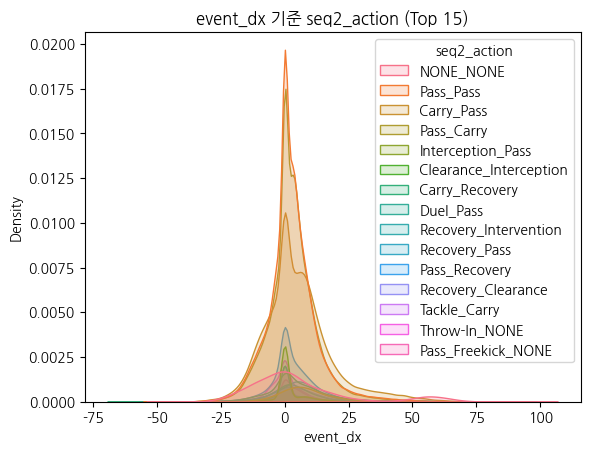

In [ ]:
#1-step + 2-step 조합
df_copy["prev2_action_type"] =df_copy.groupby("game_episode")["action_type"].shift(2)

df_copy["prev1_action_type"]  = df_copy["prev1_action_type"].fillna("NONE")
df_copy["prev2_action_type"] = df_copy["prev2_action_type"].fillna("NONE")

df_copy["seq2_action"] = df_copy["prev1_action_type"] + "_" + df_copy["prev2_action_type"]

#EDA용 dx,dy
df_copy["event_dx"] = df_copy["end_x"] - df_copy["start_x"]
df_copy["event_dy"] = df_copy["end_y"] - df_copy["start_y"]

# seq2_action 상위 15개 분포 확인 (event_dx기준)
topK = df_copy["seq2_action"].value_counts().head(15).index.tolist()
df_top = df_copy[df_copy["seq2_action"].isin(topK)]
sns.kdeplot(data=df_top, x="event_dx", hue="seq2_action", fill=True, alpha=0.2)
plt.title('event_dx 기준 seq2_action (Top 15)')
plt.show()

#seq2_action_top 변수 df에 추가
df_copy["seq2_action_top"] = df_copy["seq2_action"].where(df_copy["seq2_action"].isin(topK), "OTHER")

#사용안하는 변수 삭제
df_copy = df_copy.drop(columns=["event_dx", "event_dy", "seq2_action"])

In [ ]:
# 2. DL/Goal/Penalty Features 추가
def add_dl_features(df):
    # 이전 시작 위치
    df['prev_start_x'] = df.groupby('game_episode')['start_x'].shift(1)
    df['prev_start_y'] = df.groupby('game_episode')['start_y'].shift(1)

    dx = df['start_x'] - df['prev_start_x'] # Series
    dy = df['start_y'] - df['prev_start_y'] # Series

    # 현재 시간 - 과거 시간
    dt = df['time_seconds'] - df.groupby('game_episode')['time_seconds'].shift(1)
    dt = dt.fillna(1.0).replace(0, 0.1)

    # 속도 계산
    df['legal_speed'] = np.sqrt(dx**2 + dy**2) / dt
    df['legal_speed'] = df['legal_speed'].fillna(0.0)

    # 각도 계산
    df['move_angle'] = np.arctan2(dy, dx)
    df['move_angle_sin'] = np.sin(df['move_angle']).fillna(0.0)
    df['move_angle_cos'] = np.cos(df['move_angle']).fillna(0.0)

    df['x_zone'] = (df['start_x'] / (105 / 7)).astype(int).clip(0, 6)
    df['y_lane'] = pd.cut(
        df['start_y'],
        bins=[0, 68/3, 2*68/3, 68],
        labels=[0, 1, 2],
        include_lowest=True
    ).astype(int)

    # Goal Value 패널티 박스 플레이 가정
    OPP_GOAL_X, OPP_GOAL_Y = 105, 34
    df['dist_to_opp_goal'] = np.sqrt((df['start_x'] - OPP_GOAL_X)**2 + (df['start_y'] - OPP_GOAL_Y)**2)
    df['angle_to_opp_goal'] = np.arctan2(OPP_GOAL_Y - df['start_y'], OPP_GOAL_X - df['start_x'])
    df['angle_to_opp_goal_sin'] = np.sin(df['angle_to_opp_goal']).fillna(0.0)
    df['angle_to_opp_goal_cos'] = np.cos(df['angle_to_opp_goal']).fillna(0.0)

    PENALTY_LINE_X = 105 - 16.5  # 88.5m
    PENALTY_CENTER_Y = 34
    df['dist_to_opp_box_center'] = np.sqrt(
        (df['start_x'] - PENALTY_LINE_X)**2 + (df['start_y'] - PENALTY_CENTER_Y)**2
    )

    # 추가: 에피소드 내 이벤트 순번 (0, 1, 2, ...)
    df['episode_event_index'] = df.groupby('game_episode').cumcount()

    return df

df_copy = add_dl_features(df_copy)

# 실제 시간 추가
df_copy["match_minutes"] = df_copy["time_seconds"]/60 + (df_copy["period_id"]-1)*45

df_copy.head()

,game_id,period_id,episode_id,time_seconds,team_id,player_id,action_id,action_type,result_name,start_x,...,move_angle_cos,x_zone,y_lane,dist_to_opp_goal,angle_to_opp_goal,angle_to_opp_goal_sin,angle_to_opp_goal_cos,dist_to_opp_box_center,episode_event_index,match_minutes
0,126283,1,1,0.667,2354,344559,0,Pass,Successful,52.418205,...,0.000000,3,1,52.584313,0.009786,0.009785,0.999952,36.085464,0,0.011117
1,126283,1,1,3.667,2354,250036,2,Pass,Successful,32.013240,...,-0.975361,2,1,73.101872,-0.056127,-0.056097,0.998425,56.635419,1,0.061117
2,126283,1,1,4.968,2354,500145,4,Carry,NaN,37.371285,...,0.582957,2,1,67.712480,0.049746,0.049725,0.998763,51.239461,2,0.082800
3,126283,1,1,8.200,2354,500145,5,Pass,Successful,38.391570,...,0.167104,2,1,67.266604,0.140004,0.139547,0.990215,50.980073,3,0.136667
4,126283,1,1,11.633,2354,142106,7,Pass,Successful,34.578705,...,-0.201285,2,0,75.762127,0.377727,0.368809,0.929505,60.730940,4,0.193883


In [ ]:
df_copy["prev1_dx"] = df_copy["prev1_end_x"] - df_copy["start_x"]
df_copy["prev1_dy"] = df_copy["prev1_end_y"] - df_copy["start_y"]
df_copy["prev1_dist"] = np.sqrt(df_copy["prev1_dx"]**2 + df_copy["prev1_dy"]**2)

theta = np.arctan2(df_copy["prev1_dy"], df_copy["prev1_dx"])
df_copy["prev1_angle_sin"] = np.sin(theta)
df_copy["prev1_angle_cos"] = np.cos(theta)

#측면 전용 피처
df_copy["is_wing"] = (df_copy["start_y"] < 10) | (df_copy["start_y"] > 58)
df_copy["wing_prev1_dy"] = df_copy["prev1_dy"] * df_copy["is_wing"]

df_copy["wing_prev_angle_sin"] = df_copy["prev1_angle_sin"] * df_copy["is_wing"]
df_copy["wing_prev_angle_cos"] = df_copy["prev1_angle_cos"] * df_copy["is_wing"]

# Feature Selection

In [ ]:
DROP_COLS = [
    # ID / 메타
    "game_id", 'period_id', "episode_id", "game_episode",
    'time_seconds', 'is_train',
    "action_id", "team_id", "player_id",
    "venue", "game_day", 'game_date', 'home_team_name_ko',
    'away_team_name_ko', 'is_home',

    # 스코어 (미래 정보 가능)
    "home_score", "away_score",

    # 중간 계산 / 제거 결정
    "prev_start_x", "prev_start_y",
    "move_angle","angle_to_opp_goal",
    'dist_to_opp_box_center',
    "period_id", "action_type", 'prev2_action_type'
]

### 피처 추가시 여기에 추가 ###
FEATURE_CANDIDATES = [
    # ===== 시간 / 순서 =====
    "match_minutes",
    "episode_event_index",
    "seq2_action_top",

    # ===== 위치/이동=====
    "start_x", "start_y","legal_speed",
    "move_angle_sin", "move_angle_cos",

    # ===== lag 정보 =====
    "prev1_end_x", "prev1_end_y",

    # ===== 공간 구역 =====
    "x_zone", "y_lane",

    # ===== 골 기준 =====
    "dist_to_opp_goal",
    "angle_to_opp_goal_sin", "angle_to_opp_goal_cos",

    # ===== 이벤트 =====
    "result_name",
    "prev1_action_type",
    "prev1_result_name",

    # ===== 역할 =====
    "player_role_label", 'player_role_pass',

    # ==== 추가 ====
    'prev1_dx', 'prev1_dy', 'prev1_dist', 'prev1_angle_sin', 'prev1_angle_cos',
    'wing_prev_angle_sin', 'wing_prev_angle_cos',

    "pass_dist_mean", "pass_dist_std",
    "forward_mean", "side_move_mean",
    "dx_mean", "dy_mean"
]

CAT_CANDIDATES = [
    "result_name",
    "player_role_label",
    "seq2_action_top",
    "prev1_action_type",
    "prev1_result_name",
    "x_zone", "y_lane",
    "player_role_pass",
]

SORT_KEYS = ["game_episode", "time_seconds", "action_id"]
TARGETS = ["end_x", "end_y"]